# Determine P-value threshold at chosen a FDR threshold

In this notebook, we describe how to determine a P-value threshold for a given dataset so that the FDR is kept below a chosen threshold. We use an empirical method to estimate the FDR at given P-value thresholds. For a given P-value threshold ``p_thresh``, we proceed in four steps:

1. Determine the number of significant interactions ``sig_num_o`` at ``p_thresh``.
2. Randomize the simple and twisted read pair counts of all interactions. We randomize individual interactions with $n$ read pairs by randomly drawing a simple count from a binomial distribution with $p=0.5$ and then setting the twisted count to $t=n-s$.
3. Determine the number of randomized significant interactions ``sig_num_r`` at ``p_thresh``.
4. Use ``sig_num_r/sig_num_o`` to estimate the FDR at ``p_thresh``.

To find a P-value threshold for which the FDR is kept below a chosen threshold, we estimate the FDR for increasing P-value thresholds. Then we use the largest P-value threshold for which the FDR is still below the chosen threshold. Note that we randomize each interaction only once and then use the same list of P-values of randomized interactions for all P-value thresholds.

## Setting up the notebook

In [1]:
import sys
import os
import time
from numpy import arange
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import RandomizeInteractionSet

In this notebook, we use the following classes:
- ``DiachromaticInteractionSet``
- ``RandomizeInteractionSet``

We use the ``DiachromaticInteractionSet`` to read, evaluate, categorize and write interactions to a file. The randomization analyzes are carried out in class ``RandomizeInteractionSet``, which operates on an already existing ``DiachromaticInteractionSet`` object that has been passed to its constructor.

## Test files

### Test file 1

The purpose of the first test file is to check whether the P-value thresholds are used correctly during the FDR analysis. The function ``write_diachromatic_interaction_fdr_test_file`` of class ``DiachromaticInteractionSet`` can be used to generate a test file that contains the same number of interactions for consecutive P-value intervals of the same size. The following parameters must be specified:

- ``i_file``: Input interaction file
- ``p_value_max``: Maximum P-value
- ``p_value_step``: P-value step size
- ``i_per_interval_requested``: Requested number of interactions per interval
- ``target_file:``: Output interaction test file

Make sure that the interaction file has not previously been categorized with a P-value threshold that is smaller than the specified maximum P-value. Otherwise, interactions that do not have enough read pairs to be significant at the smaller threshold may have already been discarded.

The maximum P-value and the step size are used to create a list of P-values sorted in ascending order that define intervals of equal size. For example:

In [2]:
p_value_max = 0.05
p_value_step = 0.0025
p_threshs = arange(p_value_step, p_value_max + p_value_step, p_value_step)
print(p_threshs)

[0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02   0.0225 0.025
 0.0275 0.03   0.0325 0.035  0.0375 0.04   0.0425 0.045  0.0475 0.05  ]


For each of these intervals, the requested number of interactions is selected from the input file and written into a new interaction file that can be used for testing.

In order to create a test file for the FDR module, we first read an interactions file from real data into a ``DiachromaticInteractionSet``.

In [3]:
interaction_input_file = '../tests/data/test_03/MK_0.06_evaluated_and_categorized_interactions.tsv.gz'
interaction_set_test = DiachromaticInteractionSet()
interaction_set_test.parse_file(i_file = interaction_input_file, verbose=True)
#read_file_info_report = interaction_set_test.get_read_file_info_report()
#print(read_file_info_report)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/MK_0.06_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Parsed 5,000,000 interaction lines ...
	[INFO] Parsed 6,000,000 interaction lines ...
	[INFO] Parsed 7,000,000 interaction lines ...
	[INFO] Parsed 8,000,000 interaction lines ...
	[INFO] Parsed 9,000,000 interaction lines ...
[INFO] ... done.


Then we create the test file with the function provided for this purpose. Note that we are using a smaller step size than in the example above.

In [4]:
write_test_file_info_dict = interaction_set_test.write_diachromatic_interaction_fdr_test_file(
    target_file='../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv',
    p_value_max = 0.05,
    p_value_step = 0.00025,
    i_per_interval_requested = 10,   
    verbose=True)

[INFO] Generating test file for FDR procedure ...
	[INFO] Iterating interaction set and writing interactions to test file ...
[INFO] ... done.


The function creates the new interaction file for testing and returns a table containing the number of selected interactions for each P-value interval. For the parameters given above, this table has rows for 200 intervals. For each interval, the current and cumulative number of selected interactions is reported.

In [5]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(write_test_file_info_dict['RESULTS_TABLE'])

,PVAL_INTERVAL,I_SELECTED,I_SELECTED_CUM
0,]0.00000;0.00025],10,10
1,]0.00025;0.00050],10,20
2,]0.00050;0.00075],10,30
3,]0.00075;0.00100],10,40
4,]0.00100;0.00125],10,50
5,]0.00125;0.00150],10,60
6,]0.00150;0.00175],10,70
7,]0.00175;0.00200],10,80
8,]0.00200;0.00225],10,90
9,]0.00225;0.00250],10,100


In this case, the requested number of 10 interactions could be selected for each of the 200 P-value intervals so that the output file contains 2000 interactions.

### Test files 2

To investigate the influence of the total number of input interactions on the estimation of the FDR, we created smaller files from a real interaction file by writing the top lines to new files. We have prepared test files with ``1,000``, ``2,000``, ``4,000``, ``8,000``, ``16,000``, ``32,000``, ``64,000`` and ``8,000,000`` interactions. We did not add the file with ``8,000,000`` to this repository because it's too large.

In [6]:
ls ../tests/data/test_03/*top*

../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_16000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_32000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz


## Check that P-value thresholds are being used  correctly

During the FDR procedure, the number of sigificant interactions is determined at different P-value thresholds. In addition, P-values and logarithmized P-values are used. This can lead to errors when usinng ``<``, ``<=``, ``>`` or ``>=``. Furthermore, the transformations log(p) and exp(log(p)) can lead to inaccuracies. To check whether the thresholds are being used  correctly, we apply our FDR procedure to the test file, which contains the same number of interactions for different P-value intervals.

First, we read the test file into an ``DiachromaticInteractionSet``. When creating this file, we have defined 200 intervals and selected 10 interactions for each interval. Therefore, we expect a total of 2000 interactions.

In [7]:
interaction_set = DiachromaticInteractionSet()
interaction_set.parse_file('../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv', verbose=False)
read_file_info_report = interaction_set.get_read_file_info_report()
print(read_file_info_report)

[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 2,000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_1.tsv
			[INFO] Set size: 2,000
	[INFO] The interaction set has 2,000 interactions.
[INFO] End of report.



Then we create an object of class ``RandomizeInteractionSet`` and, at the same time, pass the interaction set to this object. Finally, we call the function for the FDR procedure. We use the same values for the maximum P-value (``pval_thresh_max``) and the step size (``pval_thresh_step_size``) that we used when creating the test file.

In [8]:
randomize_fdr = RandomizeInteractionSet(interaction_set=interaction_set)
fdr_info_dict = randomize_fdr.get_pval_thresh_at_chosen_fdr_thresh(
    chosen_fdr_thresh = 0.05,
    pval_thresh_max = 0.05,
    pval_thresh_step_size = 0.00025,
    verbose = True)

[INFO] Performing FDR procedure ...
	[INFO] Getting list of observed P-values ...
	[INFO] Getting list of randomized P-values ...
	[INFO] Going through list of P-value thresholds and estimate FDR ...
	[INFO] Looking for largest P-value threshold for which the FDR is below the chosen threshold ...
[INFO] ... done.


../diachr/randomize_interaction_set.py:145: UserWarning: Only 2000 input interactions! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:154: UserWarning: Only 1908 interactions with minimum number of 13 read pairs required for significance at the determined threshold! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:160: UserWarning: Only 0 significant interactions after randomization at determined threshold. Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')


For this example, three warnings are reported. For this constructed file, these warnings are to be expected and can be ignored. The meanings of these warnings are explained later in this notebook.

The function for the FDR procedure returns a table containing the results for all P-value thresholds. This table has the following columns:

- ``P_VAL_TRESH``: P-value threshold
- ``NNL_P_VAL_TRESH``: Negative of the natural logarithm of the P-value threshold
- ``MIN_RP_NUM``: Minimum number of read pairs at the corresponding P-value threshold
- ``MIN_RP_NUM_PVAL``: Most extreme P-value at ``MIN_RP_NUM`` (``MIN_RP_NUM-1`` cannot be not significant)
- ``SIG_NUM_R``: Number of randomized significant interactions
- ``SIG_NUM_O``: Number of observed significant interaction
- ``FDR``: Estimated FDR

Run the cell below to display this table.

In [9]:
pandas.set_option('display.max_rows', None)
pandas.DataFrame(fdr_info_dict['RESULTS_TABLE'])

,PVAL_THRESH,NNL_PVAL_THRESH,MIN_RP_NUM,MIN_RP_NUM_PVAL,SIG_NUM_R,SIG_NUM_O,FDR
0,0.00025,8.294050,13,0.000244,0,10,0.000000
1,0.00050,7.600902,12,0.000488,2,20,0.100000
2,0.00075,7.195437,12,0.000488,2,30,0.066667
3,0.00100,6.907755,11,0.000977,3,40,0.075000
4,0.00125,6.684612,11,0.000977,4,50,0.080000
5,0.00150,6.502290,11,0.000977,4,60,0.066667
6,0.00175,6.348139,11,0.000977,4,70,0.057143
7,0.00200,6.214608,10,0.001953,4,80,0.050000
8,0.00225,6.096825,10,0.001953,4,90,0.044444
9,0.00250,5.991465,10,0.001953,5,100,0.050000


The number of significant interactions in column ``SIG_NUM_O`` increases by 10 for each P-value threshold. This is what we expect for this test dataset and we are testing this in a unit test.

## Influence of the total number of interactions on the estimation of the FDR

We investigated the influence of the total number of input interactions on the estimation of the FDR by downsampling. From an interaction file with approximately ``9,000,000`` interactions, we created eight smaller interaction files by writing the first ``1,000``, ``2,000``, ``4,000``, ``8,000``, ``16,000``, ``32,000``, ``64,000`` and ``8,000,000`` lines each to a new file. Then we applied our FDR procedure with the same parameters to all files.

In [2]:
chosen_fdr_thresh = 0.05
p_value_max = 0.025
p_value_step = 0.00025

### ``1,000`` interactions

In [9]:
# Prepare interaction set
interaction_file_top_1000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz'
interaction_set_top_1000 = DiachromaticInteractionSet()
interaction_set_top_1000.parse_file(interaction_file_top_1000, verbose=False)

# Perform FDR procedure
randomize_fdr_top_1000 = RandomizeInteractionSet(interaction_set=interaction_set_top_1000, random_seed=0)
fdr_info_dict_top_1000 = randomize_fdr_top_1000.get_pval_thresh_at_chosen_fdr_thresh(
    chosen_fdr_thresh = chosen_fdr_thresh,
    pval_thresh_max = p_value_max,
    pval_thresh_step_size = p_value_step,
    verbose = False)

# Print summary of results
fdr_info_report = randomize_fdr_top_1000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 1,000
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00400
		[INFO] Determined -ln(P-value threshold): 5.52146
		[INFO] Minimum read pair number: 9
		[INFO] Smallest possible P-value with 9 read pairs: 0.00391
		[INFO] Number of interactions with 9 or more read pairs: 686
		[INFO] Number of significant interactions: 23
		[INFO] Number of randomized significant interactions: 1
		[INFO] Estimated FDR: 0.04348
	[INFO] Warnings: 
		[INFO] Not enough input interactions!
			[INFO] Only 1,000 of 16,000
		[INFO] Not enough interactions with enough read pairs required for significance!
			[INFO] Only 686 of 10,000
		[INFO] Not enough randomized significant interactions!
			[INFO] Only 1 of 20
[INFO] End of report.



../diachr/randomize_interaction_set.py:145: UserWarning: Only 1000 input interactions! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:154: UserWarning: Only 686 interactions with minimum number of 9 read pairs required for significance at the determined threshold! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:160: UserWarning: Only 1 significant interactions after randomization at determined threshold. Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')


#### Results

The function ``get_fdr_info_report`` returns a formatted string that contains informations about the input parameters and the final results. In this case, with only ``1,000`` interactions, a P-value threshold of ``0.00400`` is determined. This is the largest P-value threshold for which an FDR was estimated that was still below ``0.05``.  We use this threshold to categorize interactions as either directed or undirected. When evaluating interactions, we specify the negative of the natural logarithm of the P-value. Therefore, logarithmized theshold value is also reported, which is ``5.52146`` in this case. At the threshold that has been determined, an interaction must have at least  ``9`` read pairs in order to have a significant P-value, which corresponds to a P-value of ``0.00391``. This means that even the most extreme interaction with 8 read pairs, i.e. with only simple read pairs (``8:0``) or only twisted read pairs (``0:8``), cannot be significant at the determined threshold because the corresponding P-value ($0.00781$) is already above the threshold. Of the ``1,000`` interactions, ``686`` have ``9`` or more read pairs and therefore can potentially significant. ``23`` significant interactions were observed for the original data. After the simple and twisted read pair counts of all interactions were randomized, the number of significant interactions was ``1``. This gives an estimated FDR of ``1/23 = 0.04348``.

#### Warnings

In this case, the total number of interactions is small and more than 30% (``1000 - 686``) of the interactions cannot be significant because they do not have enough read pairs. After all, the FDR is estimated from very small numbers of interactions. If there are few input interactions or if the average number of read pairs per interaction is small, the FDR cannot be reliably estimated. In order to detect such cases, we issue warnings if:

1. The number of input interactions is below ``16,000``
2. The number of interactions with enough read pairs to be significant is below ``10,000``
3. The number of randomized significant interactions is below ``20``


#### Graphical representation of the results

If warnings are reported, we recommend taking a closer look at the results. The function ``get_fdr_info_plot`` creates a plot that contains not only the final results but also a graphical representation of all intermediate results. A text field in the header contains all informations that is also contained in the formatted string described above. Below that follows the first plot, which only contains the P-value thresholds that were passed through. The red dashed lines are drawn at the determined P-value threshold. This is followed by two plots that refer to the minimum number of read pairs that are necessary for significance at the various P-value thresholds. These upper three plots do not contain results related to the data. They result soley from the binomial model and the chosen step size for the P-value thresholds and serve as a reference for the interpretation for the lower two plots. The one plot shows the number of significant interactions for the original (orange) and randomized (blue) data and the plot at the bottom shows the estimated FDR at the different P-value thresholds.

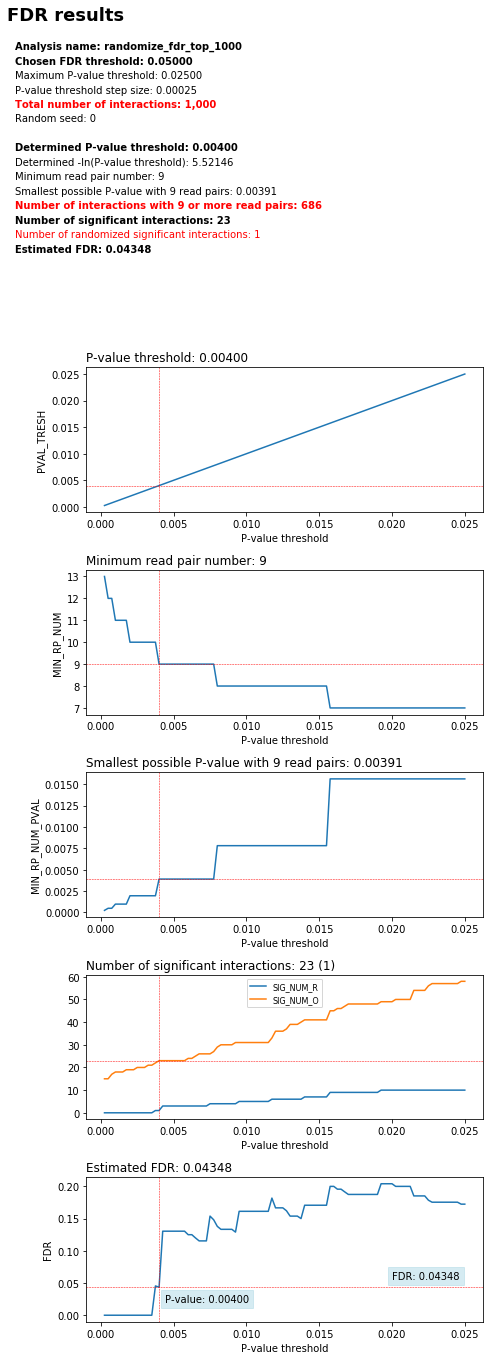

In [10]:
# Create plot with a summary of the FDR analysis
fig = randomize_fdr_top_1000.get_fdr_info_plot(
    pdf_file_name = 'randomize_fdr_top_1000.pdf',
    analysis_name = 'randomize_fdr_top_1000')

In this example, the FDR estimated for different P-value thresholds shows an unsual trend. First of all, it is nocticable that the FDR increases sharply at some P-value thresholds including the one that was determined as the largest threshold that yields an FDR which is still below the chosen FDR threshold of ``0.05``. Another point at which the FDR increases sharply is at the transition from eight to seven read pairs required for significance. In addition, it happens that the FDR decreases with increasing P-value thresholds. Typically, one would expect the FDR to grow monotonically with the P-value threshold. In thus case the FDR could not be reliably estimated and the P-value threshold should not be used.

### ``64,000`` interactions

Next, we apply our FDR procedure to the file with ``64,000`` interactions.

In [11]:
# Prepare interaction set
interaction_file_top_64000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz'
interaction_set_top_64000 = DiachromaticInteractionSet()
interaction_set_top_64000.parse_file(interaction_file_top_64000, verbose=False)

# Perform FDR procedure
randomize_fdr_top_64000 = RandomizeInteractionSet(interaction_set=interaction_set_top_64000, random_seed=0)
fdr_info_dict_top_64000 = randomize_fdr_top_64000.get_pval_thresh_at_chosen_fdr_thresh(
    chosen_fdr_thresh = chosen_fdr_thresh,
    pval_thresh_max = p_value_max,
    pval_thresh_step_size = p_value_step,
    verbose = False)

# Print summary of results
fdr_info_report = randomize_fdr_top_64000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 64,000
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value threshold): 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Smallest possible P-value with 10 read pairs: 0.00195
		[INFO] Number of interactions with 10 or more read pairs: 38,749
		[INFO] Number of significant interactions: 1,585
		[INFO] Number of randomized significant interactions: 77
		[INFO] Estimated FDR: 0.04858
[INFO] End of report.



In this case, no warning is issued. The determined P-value threshold is ``0.00375``. At this P-value threshold is with ``0.04858`` below the specified ``0.05``.

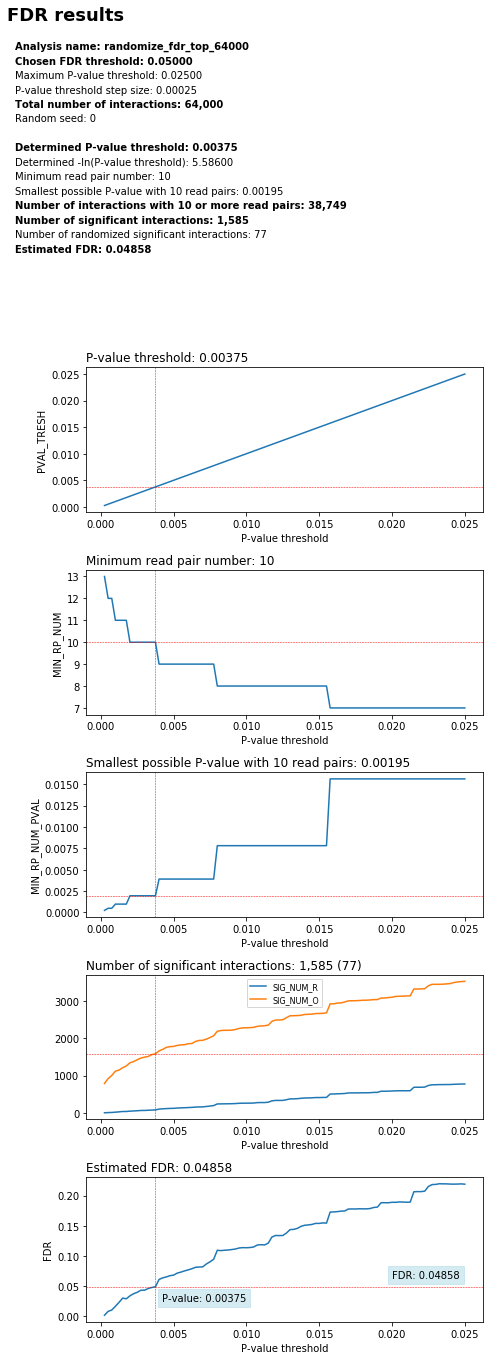

In [12]:
# Create plot with a summary of the FDR analysis
fig = randomize_fdr_top_64000.get_fdr_info_plot(
    pdf_file_name = 'randomize_fdr_top_64000.pdf',
    analysis_name = 'randomize_fdr_top_64000')

For this example, the FDR increases monotonically as expected. Three abrupt increases can be seen to the right of the determined P-value threshold. The first two increases fall in the transitions to fewer read pairs that are required for significanc (``9`` to ``8`` and ``8`` to ``7``). The third increase is at a P-value threshold of about ``0.022``.

### ``1,000``, ``2,000``, ``4,000``, ``8,000``, ``16,000``, ``32,000``, ``64,000`` interactions

In order to get an impression of how many input interactions are needed for a reliable estimate of the FDR, we apply the procedure to all prepared files.

In [15]:
fdr_results = {}
for i_num in [1000, 2000, 4000, 8000, 16000, 32000, 64000]:
    
    # Prepare interaction set
    i_file = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_' + str(i_num) +'.tsv.gz'
    print(i_file)
    i_set = DiachromaticInteractionSet()
    i_set.parse_file(i_file, verbose=False)

    # Perform FDR procedure
    randomize_fdr = RandomizeInteractionSet(interaction_set=i_set, random_seed=0)
    fdr_results[i_num] = randomize_fdr.get_pval_thresh_at_chosen_fdr_thresh(
        chosen_fdr_thresh = chosen_fdr_thresh,
        pval_thresh_max = p_value_max,
        pval_thresh_step_size = p_value_step,
        verbose = False)
    
    time.sleep(1)
    

../tests/data/test_03/diachromatic_interaction_file_fdr_top_1000.tsv.gz


../diachr/randomize_interaction_set.py:145: UserWarning: Only 1000 input interactions! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:154: UserWarning: Only 686 interactions with minimum number of 9 read pairs required for significance at the determined threshold! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:160: UserWarning: Only 1 significant interactions after randomization at determined threshold. Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_2000.tsv.gz


../diachr/randomize_interaction_set.py:145: UserWarning: Only 2000 input interactions! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:154: UserWarning: Only 1516 interactions with minimum number of 8 read pairs required for significance at the determined threshold! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:160: UserWarning: Only 3 significant interactions after randomization at determined threshold. Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_4000.tsv.gz


../diachr/randomize_interaction_set.py:145: UserWarning: Only 4000 input interactions! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:154: UserWarning: Only 2201 interactions with minimum number of 11 read pairs required for significance at the determined threshold! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:160: UserWarning: Only 3 significant interactions after randomization at determined threshold. Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000.tsv.gz


../diachr/randomize_interaction_set.py:145: UserWarning: Only 8000 input interactions! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:154: UserWarning: Only 4762 interactions with minimum number of 10 read pairs required for significance at the determined threshold! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:160: UserWarning: Only 7 significant interactions after randomization at determined threshold. Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_16000.tsv.gz


../diachr/randomize_interaction_set.py:154: UserWarning: Only 9665 interactions with minimum number of 10 read pairs required for significance at the determined threshold! Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')
../diachr/randomize_interaction_set.py:160: UserWarning: Only 18 significant interactions after randomization at determined threshold. Probably not enough to estimate the FDR.
  'Probably not enough to estimate the FDR.')


../tests/data/test_03/diachromatic_interaction_file_fdr_top_32000.tsv.gz
../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz


From ``32,000`` input interactions onwards, no warnings are issued. Run the cell below to plot the FDR for all input files.

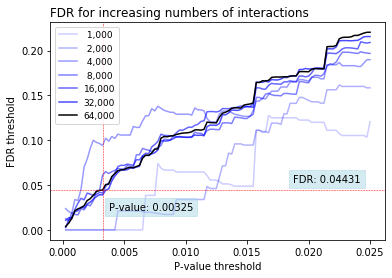

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

pval_threshs = fdr_results[1000]['RESULTS_TABLE']['PVAL_THRESH']

plt.plot(pval_threshs, fdr_results[1000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.2), label=' ' + "{:,}".format(1000))
plt.plot(pval_threshs, fdr_results[2000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.3), label=' ' + "{:,}".format(2000))
plt.plot(pval_threshs, fdr_results[4000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.4), label=' ' + "{:,}".format(4000))
plt.plot(pval_threshs, fdr_results[8000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.5), label=' ' + "{:,}".format(8000))
plt.plot(pval_threshs, fdr_results[16000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.6), label="{:,}".format(16000))
plt.plot(pval_threshs, fdr_results[32000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.7), label="{:,}".format(32000))
plt.plot(pval_threshs, fdr_results[64000]['RESULTS_TABLE']['FDR'], color=(0,0,0,1), label="{:,}".format(64000))

result_index = fdr_results[64000]['RESULT_INDEX'][0]
fdr_result = fdr_results[64000]['RESULTS_TABLE']['FDR'][result_index]
pval_thresh_result = fdr_results[64000]['RESULTS_TABLE']['PVAL_THRESH'][result_index]
plt.axhline(fdr_result, linestyle='--', color='red', linewidth=0.5)
plt.axvline(pval_thresh_result, linestyle='--', color='red', linewidth=0.5)

fdr_max = max(fdr_results[64000]['RESULTS_TABLE']['FDR'])
pval_max = fdr_results[64000]['INPUT_PARAMETERS']['PVAL_THRESH_MAX'][0]
fdr_x = pval_max - pval_max/4
fdr_y = fdr_result + fdr_max/25
pval_x = pval_thresh_result + pval_max/50
pval_y = fdr_result - fdr_max/10
plt.text(fdr_x, fdr_y,'FDR: ' + "{:.5f}".format(fdr_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.text(pval_x, pval_y,'P-value: ' + "{:.5f}".format(pval_thresh_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.xlabel('P-value threshold')
plt.ylabel('FDR threshold')

plt.title('FDR for increasing numbers of interactions', loc='left')
plt.legend(fontsize=9)

plt.savefig('fdr_for_increasing_numbers_of_interactions.pdf')
plt.show()

The black line shows the FDR estimates for ``64,000`` input interactions. For the other interaction numbers, the FDR estimates are shown in blue, with the lines becoming darker with increasing interaction numbers. Up to ``8,000`` input interactions the FDR estimates show an unusual trend. From ``16,000`` onwards, the estimates stabilize.

### ``8,000,000`` interactions

Finally, we wanted to find out how the estimates change beyond ``64,000`` input interactions. We applied the procedure to the file with ``8,000,000`` interactions.

In [13]:
# Prepare interaction set
interaction_file_top_8000000 = '../tests/data/test_03/diachromatic_interaction_file_fdr_top_8000000.tsv.gz'
interaction_set_top_8000000 = DiachromaticInteractionSet()
interaction_set_top_8000000.parse_file(interaction_file_top_8000000, verbose=False)

# Perform FDR procedure
randomize_fdr_top_8000000 = RandomizeInteractionSet(interaction_set=interaction_set_top_8000000, random_seed=0)
fdr_info_dict_top_8000000 = randomize_fdr_top_8000000.get_pval_thresh_at_chosen_fdr_thresh(
    chosen_fdr_thresh = chosen_fdr_thresh,
    pval_thresh_max = p_value_max,
    pval_thresh_step_size = p_value_step,
    verbose = False)

# Print summary of results
fdr_info_report = randomize_fdr_top_8000000.get_fdr_info_report()
print(fdr_info_report)

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.02500
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 8,000,000
		[INFO] Random seed: 0
	[INFO] Results:
		[INFO] Determined P-value threshold: 0.00375
		[INFO] Determined -ln(P-value threshold): 5.58600
		[INFO] Minimum read pair number: 10
		[INFO] Smallest possible P-value with 10 read pairs: 0.00195
		[INFO] Number of interactions with 10 or more read pairs: 4,886,564
		[INFO] Number of significant interactions: 196,005
		[INFO] Number of randomized significant interactions: 9,482
		[INFO] Estimated FDR: 0.04838
[INFO] End of report.



As compared to ``64,000`` input interactions, we determine the same P-value threshold of ``0.00375`` and the associated FDR (``0.04858`` vs. ``0.04838``) changes only slightly.

Because the file with ``8,000,000`` is too large to add to the repository, the results can also be read into variables by running the cell below.

In [18]:
randomize_fdr_top_8000000 = [0.004607580813454962, 0.008926292067572207, 0.01196276458440888, 0.01839632218580503, 0.01951779563719862, 0.022965555006477636, 0.025001132004683266, 0.03202887652278538, 0.03367523879500368, 0.0368678258893056, 0.040147390419622724, 0.04124723391330759, 0.042197708043268715, 0.04642056137697412, 0.047957960256115914, 0.056833284200250335, 0.06027492670346788, 0.06367092666391828, 0.06489780797657986, 0.06516133967502576, 0.06668620841272167, 0.067671657838843, 0.0682215436914895, 0.07008764196442463, 0.07051838731589039, 0.0767696867766806, 0.07888236667581507, 0.07899784469537408, 0.08203040304512274, 0.0861228584354531, 0.089317946898286, 0.10357017254444134, 0.10479357262253536, 0.10491360710529056, 0.10534351145038168, 0.10569731985235115, 0.10662693666083928, 0.10854725339221084, 0.1094512851497663, 0.10967518406236466, 0.10981567075364645, 0.11032146217554792, 0.11320409222077918, 0.11359356245668013, 0.11391995142437888, 0.11521744953858105, 0.12461125521014801, 0.12728170180243298, 0.12746722821125359, 0.12765362596026153, 0.1326131189439337, 0.13767482782682564, 0.13777583808406754, 0.1384791757802483, 0.13958065588798318, 0.14041607852246263, 0.14065828923245152, 0.14101009142480955, 0.1427259589772871, 0.14297844334952212, 0.1433052492099508, 0.1441012859202531, 0.16874471710698652, 0.16881052799162424, 0.17017464453770484, 0.17042024983493145, 0.17174850912292144, 0.173948150070652, 0.17411423947287788, 0.17413287041037281, 0.17452673747215527, 0.17470481297649199, 0.17473819771579624, 0.17519485448958264, 0.1759955480205516, 0.17607859977338927, 0.18024193445978723, 0.1802715129726532, 0.18100996812224865, 0.18156456287536923, 0.1832667926559117, 0.1837183278714731, 0.18405242900446714, 0.18419794167754278, 0.18424458748388317, 0.20086759536029178, 0.2008967367051385, 0.20095524126416836, 0.20144100519127153, 0.20813345236763334, 0.2104217924995086, 0.21049458675306787, 0.210578441546722, 0.2106701357496669, 0.21139415126896255, 0.2116032912426551, 0.21312118463311186, 0.21410254135018103, 0.21440574210560107, 0.2146420900983711]
randomize_fdr_top_8000000_result_idx = 14

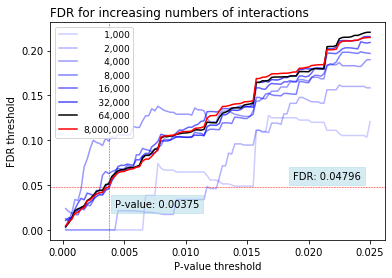

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

pval_threshs = fdr_results[1000]['RESULTS_TABLE']['PVAL_THRESH']

plt.plot(pval_threshs, fdr_results[1000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.2), label='       ' + "{:,}".format(1000))
plt.plot(pval_threshs, fdr_results[2000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.3), label='       ' + "{:,}".format(2000))
plt.plot(pval_threshs, fdr_results[4000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.4), label='       ' + "{:,}".format(4000))
plt.plot(pval_threshs, fdr_results[8000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.5), label='       ' + "{:,}".format(8000))
plt.plot(pval_threshs, fdr_results[16000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.6), label='     ' + "{:,}".format(16000))
plt.plot(pval_threshs, fdr_results[32000]['RESULTS_TABLE']['FDR'], color=(0,0,1,0.7), label='     ' + "{:,}".format(32000))
plt.plot(pval_threshs, fdr_results[64000]['RESULTS_TABLE']['FDR'], color=(0,0,0,1), label='     ' + "{:,}".format(64000))
plt.plot(pval_threshs, randomize_fdr_top_8000000, color=(1,0,0,1), label="{:,}".format(8000000))

result_index = 14
fdr_result = randomize_fdr_top_8000000[result_index]
pval_thresh_result = fdr_results[64000]['RESULTS_TABLE']['PVAL_THRESH'][result_index]
plt.axhline(fdr_result, linestyle='--', color='red', linewidth=0.5)
plt.axvline(pval_thresh_result, linestyle='--', color='red', linewidth=0.5)

fdr_max = max(fdr_results[64000]['RESULTS_TABLE']['FDR'])
pval_max = fdr_results[64000]['INPUT_PARAMETERS']['PVAL_THRESH_MAX'][0]
fdr_x = pval_max - pval_max/4
fdr_y = fdr_result + fdr_max/25
pval_x = pval_thresh_result + pval_max/50
pval_y = fdr_result - fdr_max/10
plt.text(fdr_x, fdr_y,'FDR: ' + "{:.5f}".format(fdr_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.text(pval_x, pval_y,'P-value: ' + "{:.5f}".format(pval_thresh_result), bbox={'color': 'lightblue', 'alpha': 0.5, 'pad': 4})
plt.xlabel('P-value threshold')
plt.ylabel('FDR threshold')

plt.title('FDR for increasing numbers of interactions', loc='left')
plt.legend(fontsize=9)

plt.savefig('fdr_for_increasing_numbers_of_interactions.pdf')
plt.show()

The FDR estimates for ``8,000,000`` input interactions differ only slightly from those for ``64,000`` input interactions.

## Integration of the FDR module in the script for evaluation and categorization of interactions

We have integrated the FDR module into the script for evaluating and categorizing interactions. If this script is called without a P-value threshold being passed, a P-value threshold is determined using the FDR procedure.

[INFO] Input parameters
	[INFO] --out-prefix: DEMO
	[INFO] --diachromatic-interaction-file: ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
	[INFO] --p-value-threshold: None
		[INFO] Will determine a P-value threshold so that the FDR is kept below: 0.05
		[INFO] Will use a P-value threshold step size of: 0.00025
		[INFO] Use '--fdr-threshold' to set your own FDR threshold.
		[INFO] Or use '--p-value-threshold' to skip the FDR procedure.

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
[INFO] ... done.
[INFO] Performing FDR procedure ...
	[INFO] Getting list of observed P-values ...
	[INFO] Getting list of randomized P-values ...
	[INFO] Going through list of P-value thresholds and estimate FDR ...
	[INFO] Looking for largest P-value threshold for which the FDR is below the chosen threshold ...
[INFO] ... done.
[INFO] Evaluate and categorize interactions ...
[INFO] ...done.
[INFO] 

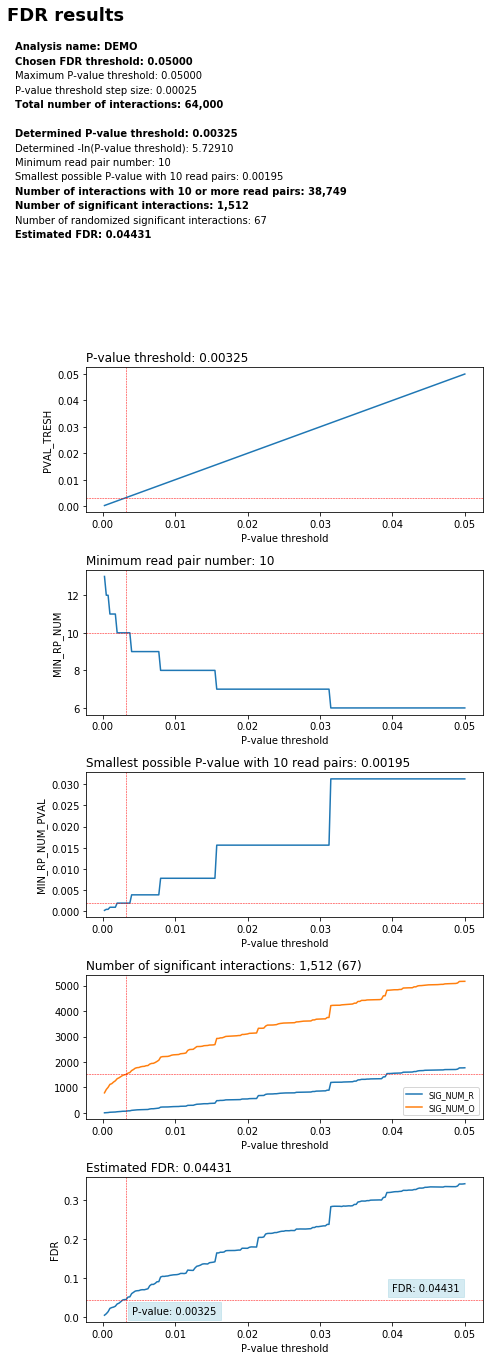

In [20]:
%run ../03_evaluate_and_categorize_interactions.py \
--out-prefix DEMO \
--diachromatic-interaction-file ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz

In this case, the file with the summary statistics is extended to include the corresponding report (``[INFO] Report on FDR procedure``) and table rows (``:TR_FDR:``).

In [21]:
cat DEMO_evaluated_and_categorized_summary.txt

[INFO] Input parameters
	[INFO] --out-prefix: DEMO
	[INFO] --diachromatic-interaction-file: ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
	[INFO] --p-value-threshold: None
		[INFO] Will determine a P-value threshold so that the FDR is kept below: 0.05
		[INFO] Will use a P-value threshold step size of: 0.00025
		[INFO] Use '--fdr-threshold' to set your own FDR threshold.
		[INFO] Or use '--p-value-threshold' to skip the FDR procedure.

[INFO] Report on reading files:
	[INFO] Read interaction data from 1 files:
		[INFO] 64,000 interactions from: 
			[INFO] ../tests/data/test_03/diachromatic_interaction_file_fdr_top_64000.tsv.gz
			[INFO] Set size: 64,000
	[INFO] The interaction set has 64,000 interactions.
[INFO] End of report.

[INFO] Report on FDR procedure:
	[INFO] Input parameters:
		[INFO] Chosen FDR threshold: 0.05000
		[INFO] Maximum P-value threshold: 0.05000
		[INFO] P-value threshold step size: 0.00025
		[INFO] Total number of interactions: 64,000
	[